<a href="https://colab.research.google.com/github/oixchi/mathesis/blob/main/cleanup_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

def gather_all_ebrains_links(base_url):
    # Function to gather and return all unique links from a base URL and its linked pages
    def get_ebrains_links(url):
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        all_links = soup.find_all('a', href=True)

        # Use list comprehension to filter and process links
        filtered_links = [urljoin(url, link['href']) for link in all_links if 'ebrains.eu' in urljoin(url, link['href'])]
        unique_links = sorted(list(set(filtered_links)))
        return unique_links

    ebrains_links = get_ebrains_links(base_url)
    all_links = set(ebrains_links)

    for link in ebrains_links:
        page_links = get_ebrains_links(link)
        all_links.update(page_links)

    return sorted(list(all_links))

# Call the function and print the results
base_url = 'https://www.ebrains.eu/'
all_ebrains_links = gather_all_ebrains_links(base_url)
all_ebrains_links_without_pdf = [link for link in all_ebrains_links if not link.endswith('.pdf') and '@' not in link]
all_ebrains_links_with_pdf = [link for link in all_ebrains_links if link.endswith('.pdf')]

print(len(all_ebrains_links_without_pdf))
print(len(all_ebrains_links_with_pdf))

for link in all_ebrains_links_without_pdf:
  print(link)
print("---------------")
for link in all_ebrains_links_with_pdf:
  print(link)

In [ ]:
import requests
from bs4 import BeautifulSoup

def scrape_website(url):
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')

        for tag in soup.find_all(['p', 'div', 'h1', 'h2', 'h3']):
            if tag.name == 'div':
                for p_tag in tag.find_all('p'):
                    text = p_tag.get_text().strip()
                    if text:  # Check if the line is not empty
                        if not text.endswith('.') and not text.endswith(':'):
                            text += '.' # make sentences out of the extracted information
                        print(text)
            else:
              text = tag.get_text().strip()
              if text:  # Check if the line is not empty
                  if not text.endswith('.') and not text.endswith(':'):
                      text += '.'
                  print(text)

    except requests.exceptions.RequestException as e:
        print(f"Error fetching URL: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

url_to_scrape = "https://www.ebrains.eu/projects"
scrape_website(url_to_scrape)


In [59]:
from google.colab import files
import os

uploaded = files.upload()

print("Files in current directory:")
print(os.listdir())

Saving chunks_dataset.txt to chunks_dataset.txt
Files in current directory:
['.config', 'dataset_some_processing.txt', 'chunks_dataset.txt', 'dataset_some_processing (2).txt', 'dataset_some_processing (1).txt', 'dataset_some_processing (3).txt', 'sample_data']


In [ ]:
!pip install pymupdf

import requests
import fitz  # pymupdf
import io
from bs4 import BeautifulSoup

def read_urls_from_file(file_path):
    # Reads all URLS from the subset_ebrains_links.txt
    with open(file_path, 'r', encoding='utf-8') as file:
        urls = file.readlines()
    return [url.strip() for url in urls]  # Remove any leading/trailing whitespace or newline characters

def extract_text_from_pdf(pdf_url, txt_file):
    try:
        # Download the PDF into memory
        response = requests.get(pdf_url)
        if response.status_code == 200:
            pdf_data = io.BytesIO(response.content)
            document = fitz.open(stream=pdf_data, filetype="pdf")  # Open directly from the BytesIO object
        else:
            print(f"Failed to download PDF from {pdf_url}. Status code: {response.status_code}")
            return

        # Iterate over each page in the PDF and extract the text
        full_text = ""
        for page_num in range(document.page_count):
            page = document.load_page(page_num)  # Load each page separately
            text = page.get_text()  # Extract text from the current page

            if text:  # Ensure there's text on the page
                # Ensure the text ends with a dot
                if not text.endswith(('.', ':')):
                    text += '.'

                # Remove line breaks, then add line breaks after every dot
                text = text.replace("\n", " ")  # Remove unwanted line breaks
                text = text.replace(". ", ".\n")  # Replace each dot followed by space with a dot and line break

                full_text += text

        document.close()

        # Append the cleaned-up text to the txt file
        with open(txt_file, "a", encoding="utf-8") as file:
            file.write(full_text + "\n")

        print(f"Text extracted and appended successfully to '{txt_file}' from PDF: {pdf_url}")

    except Exception as e:
        print(f"An error occurred: {e}")

def scrape_ebrains_links_and_extract_text(urls_file, output_txt_file):
    # Scrapes URLs for content and extracts text
    urls = read_urls_from_file(urls_file)

    for url in urls:
        try:
            if url.startswith("https://files."):  # If it's a PDF file
                print(f"Extracting text from PDF: {url}")
                extract_text_from_pdf(url, output_txt_file)
            else:
                print(f"Scraping URL: {url}")
                response = requests.get(url)

                if response.status_code != 200:
                    print(f"Failed to retrieve {url}. Status code: {response.status_code}")
                    continue

                # Parse the HTML content using BeautifulSoup
                soup = BeautifulSoup(response.text, 'html.parser')

                # Open the output text file in append mode
                with open(output_txt_file, "a", encoding="utf-8") as file:
                    for tag in soup.find_all(['p', 'div', 'h1', 'h2', 'h3']):
                        if tag.name == 'div':
                            for p_tag in tag.find_all('p'):
                                text = p_tag.get_text().strip()
                                if text:  # Check if the line is not empty
                                    if not text.endswith('.') and not text.endswith(':'):
                                        text += '.'
                                    file.write(text + "\n")
                        else:
                            text = tag.get_text().strip()
                            if text:  # Check if the line is not empty
                                if not text.endswith('.') and not text.endswith(':'):
                                    text += '.'
                                file.write(text + "\n")

        except Exception as e:
            print(f"An error occurred while processing {url}: {e}")

subset_ebrains_links = 'subset_ebrains_links.txt'
output_txt_file = 'dataset_no_processing.txt'

scrape_ebrains_links_and_extract_text(subset_ebrains_links, output_txt_file)


Scraping URL: https://www.ebrains.eu/
Scraping URL: https://www.ebrains.eu/about
Scraping URL: https://www.ebrains.eu/about#national-nodes
Scraping URL: https://www.ebrains.eu/about#roadmap
Scraping URL: https://www.ebrains.eu/about#vision
Scraping URL: https://www.ebrains.eu/brain-atlases/analysis
Scraping URL: https://www.ebrains.eu/brain-atlases/analysis/atlas-driven-analysis-resources
Scraping URL: https://www.ebrains.eu/brain-atlases/analysis/gene-expression-analysis-in-human-brain-atlas-regions
Scraping URL: https://www.ebrains.eu/brain-atlases/analysis/image-annotation-and-export-of-coordinate-points
Scraping URL: https://www.ebrains.eu/brain-atlases/analysis/labelled-features-analysis
Scraping URL: https://www.ebrains.eu/brain-atlases/apis
Scraping URL: https://www.ebrains.eu/brain-atlases/apis/http-api
Scraping URL: https://www.ebrains.eu/brain-atlases/apis/python-client
Scraping URL: https://www.ebrains.eu/brain-atlases/collaboratory-2
Scraping URL: https://www.ebrains.eu/bra

In [ ]:
files.download('dataset_no_processing.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
import time

start_time = time.time()
print(f"Function call started at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start_time))}")

end_time = time.time()
print(f"Function call ended at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(end_time))}")

# Calculate elapsed time
elapsed_time = end_time - start_time
elapsed_minutes = elapsed_time / 60

print(f"Total time taken: {elapsed_time:.2f} seconds ({elapsed_minutes:.2f} minutes)")

Function call started at: 2025-02-05 08:47:52
Function call ended at: 2025-02-05 08:47:52
Total time taken: 0.00 seconds (0.00 minutes)


In [ ]:
!pip install faiss-cpu
!pip install sentence_transformers

Overlap
Chunk 1: 44 words
Explore the EBRAINS Knowledge Graph and find the data and models that will help you make your next discovery. The EBRAINS KG brings together information from different fields of brain research, and connects research data to software that will help you analyse the data.
----------
Chunk 2: 67 words
Explore the EBRAINS Knowledge Graph and find the data and models that will help you make your next discovery. The EBRAINS KG brings together information from different fields of brain research, and connects research data to software that will help you analyse the data. At the core of the EBRAINS Knowledge Graph lies a graph database linking neuroscientific research across modalities based on the openMINDS metadata model.
----------
Chunk 3: 63 words
to software that will help you analyse the data. At the core of the EBRAINS Knowledge Graph lies a graph database linking neuroscientific research across modalities based on the openMINDS metadata model. This makes it pos

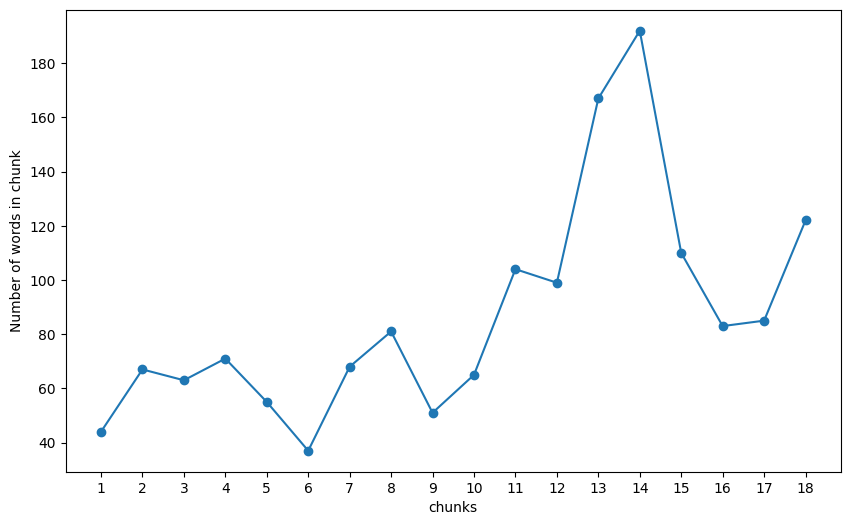

In [72]:
import re
import numpy as np
import matplotlib.pyplot as plt

with open("chunks_dataset.txt", "r", encoding="utf-8") as file:
  text = file.read()

def split_text_into_chunks(text, max_words):
    sentences = re.split(r'(?<=[.!?]) +', text)
    chunks = []
    current_chunk = []
    current_length = 0
    for sentence in sentences:
        words = sentence.split()
        if current_length + len(words) > max_words:
            chunks.append(" ".join(current_chunk))
            current_chunk = []
            current_length = 0
        current_chunk.append(sentence)
        current_length += len(words)
    chunks.append(" ".join(current_chunk))
    return chunks

def split_text_into_chunks_with_overlap(text, max_words, overlap_words):
    sentences = re.split(r'(?<=[.!?]) +', text)
    chunks = []
    current_chunk = []
    current_word_count = 0

    for sentence in sentences:
        sentence_word_count = len(sentence.split())

        # Check if adding this sentence would exceed max_words
        if current_word_count + sentence_word_count <= max_words:
            current_chunk.append(sentence)
            current_word_count += sentence_word_count
        else:
            if current_chunk:
                # Append the current chunk before starting a new one
                chunks.append(" ".join(current_chunk))

                # Calculate overlap and create a new chunk with overlapping words
                overlap_sentences = " ".join(current_chunk[-overlap_words:]) if overlap_words < len(current_chunk) else " ".join(current_chunk)
                current_chunk = overlap_sentences.split()  # Start new chunk with overlapping content

                # Reset word count based on the new chunk
                current_word_count = len(current_chunk)

            # Add the current sentence to the new chunk
            current_chunk.append(sentence)
            current_word_count += sentence_word_count

    # Append any remaining content as a final chunk
    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks

max_words=50
overlap_words=10
if overlap_words == 0:
  print("No overlap")
  chunks = split_text_into_chunks(text, max_words)
else:
  print("Overlap")
  chunks = split_text_into_chunks_with_overlap(text, max_words,overlap_words)


for i in range(len(chunks)):
    words_in_chunk = len(chunks[i].split())
    print(f"Chunk {i + 1}: {words_in_chunk} words")
    print(chunks[i])

    if i < len(chunks) - 1:
        print("----------")


x_values = list(range(1, len(chunks) + 1))
words_in_chunks = [len(chunk.split()) for chunk in chunks]

plt.figure(figsize=(10, 6))
plt.plot(x_values, words_in_chunks, marker='o', linestyle='-')

plt.xlabel("chunks with overlap")
plt.ylabel("Number of words in chunk")

plt.xticks(x_values)
#plt.yticks(words_in_chunks)

plt.show()



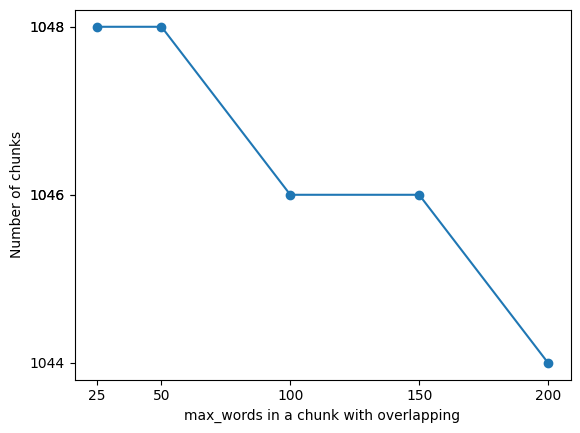

In [55]:
import matplotlib.pyplot as plt

# Sample data
x = [25, 50, 100, 150, 200]
y = [1048, 1048, 1046, 1046, 1044]

# Create the plot
plt.plot(x, y, marker='o', linestyle='-')

# Add labels
plt.xlabel("max_words in a chunk with overlapping")
plt.ylabel("Number of chunks")
#plt.title("Test")

# Set ticks for x and y axes to show only the specific values
plt.xticks(x)
plt.yticks(y)

# Show the plot
plt.show()


In [74]:
max_words=50
overlap_words=0




No overlap
Explore the EBRAINS Knowledge Graph and find the data and models that will help you make your next discovery. The EBRAINS KG brings together information from different fields of brain research, and connects research data to software that will help you analyse the data.
